# Neural Graph Collaborative Filtering (NGCF) — Notebook Tutorial


Este notebook é uma tradução didática do script original para um fluxo em células. Cada seção contém: teoria resumida, código executável e visualizações / amostras intermediárias.
Referência: Wang et al., *Neural Graph Collaborative Filtering* (SIGIR 2019).

## Introdução

**Objetivo:** explicar e executar uma implementação NGCF passo a passo.

**O que veremos:**
- Preparação dos dados (MovieLens 100k)
- Construção do grafo bipartido usuário–item
- Definição do modelo NGCF (propagação de embeddings)
- Treinamento com loss BPR e avaliação top-K (Precision, Recall, NDCG, MRR)
- Visualizações: amostras, grafos de vizinhança, loss/métricas e recomendações

## Seção 1 — Configurações Iniciais e Hiperparâmetros

Nessa seção são carregadas as bilbiotecas e realizadas configuração de dispositivo e hiperparâmetros.

In [ ]:
# Importações de bibliotecas
import warnings
warnings.filterwarnings("ignore", message="torch.sparse.*")

import pandas as pd
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import networkx as nx
import random
import scipy.sparse as sp
import time

from surprise import Dataset, Reader, KNNWithMeans
from surprise.model_selection import train_test_split as surprise_split
#from implicit.bpr import BayesianPersonalizedRanking
#from implicit.evaluation import mean_average_precision_at_k
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from matplotlib.lines import Line2D

Abaixo temos as descrições dos hiperparâmetros e outras configurações. Cada parâmetro controla um aspecto específico do modelo ou do treinamento:

- **BATCH_SIZE**: indica o número de amostras processadas por iteração. Tem influência uso de memória e estabilidade da otimização.
- **DEVICE**: define se o modelo rodará na GPU (cuda) ou CPU, conforme disponibilidade.
- **EMBED_DIM**: dimensão dos embeddings de usuários e itens. Controla a capacidade de representação do modelo.
- **EPOCHS**: número total de épocas de treinamento (passagens completas sobre o conjunto de treino).
- **LR**: taxa de aprendizado do otimizador (velocidade de atualização dos parâmetros).
- **L2_REG**: coeficiente de regularização L2 aplicado aos pesos, ajuda a evitar overfitting.
- **NUM_LAYERS**: quantidade de camadas de propagação no grafo (profundidade do NGCF).
- **TOP_K**: número de itens considerados nas métricas top-K (Precision@K, Recall@K etc.).
- **USER_ID_TEST**: usuário específico usado como exemplo em visualizações e recomendações.

In [ ]:
# Hiperparâmetros e configurações
BATCH_SIZE = 1024
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBED_DIM = 512
EPOCHS = 10
L2_REG = 1e-5
LR = 0.001
NUM_LAYERS = 3
TOP_K = 10
USER_ID_TEST = 1

print("=" * 20 + f" DISPOSITIVO USADO " + "=" * 21)
print(f"Nome do dispositivo ('cpu' ou 'cuda'): {DEVICE}")
print("=" * 60)

## Seção 2 — Carregamento e Pré-processamento do Dataset

Nesta seção, fornecemos uma descriação detalhada do **dataset** e da estratégia **Leave-One-Out (LOO)**.

### Dataset e Mapeamentos


Em primeiro lugar, o **MovieLens 100k** é um dataset clássico de recomendação que contém **interações explícitas** entre usuários e itens, no formato `(user_id, item_id, rating, timestamp)`. Cada linha representa a avaliação de um usuário a um filme em um determinado instante.

In [ ]:
# Download do MovieLens
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
try:
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    z = zipfile.ZipFile(io.BytesIO(r.content))
    ratings_df = pd.read_csv(
        z.open('ml-100k/u.data'), sep='\t',
        names=['user_id', 'item_id', 'rating', 'timestamp']
    )
    items_df = pd.read_csv(
        z.open('ml-100k/u.item'), sep='|', encoding='latin-1',
        names=['item_id', 'title'] + [f'col{i}' for i in range(22)],
        usecols=['item_id', 'title']
    )
    item_id_to_title = dict(zip(items_df.item_id, items_df.title))
except requests.exceptions.RequestException as e:
    raise RuntimeError(f"ERRO ao baixar o dataset MovieLens: {e}")
except Exception as e:
    raise RuntimeError(f"ERRO ao processar o dataset MovieLens: {e}")

# Mapear IDs para índices contínuos
u_unique = sorted(ratings_df.user_id.unique())
user_map = {old: new for new, old in enumerate(u_unique)}
user_map_reverse = {new: old for old, new in user_map.items()}
i_unique = sorted(ratings_df.item_id.unique())
item_map = {old: new for new, old in enumerate(i_unique)}
item_map_reverse = {new: old for new, old in item_map.items()}
ratings_df['user_id'] = ratings_df['user_id'].map(user_map)
ratings_df['item_id'] = ratings_df['item_id'].map(item_map)
num_users = len(user_map)
num_items = len(item_map)
num_nodes = num_users + num_items

print("Amostra de ratings (5 primeiras linhas):")
print(ratings_df.head().to_markdown(index=False))

### Divisão em Treino, Validação e Teste com Leave-One-Out (LOO)

Para preparar os conjuntos de treino, validação e teste, utilizamos a estratégia **Leave-One-Out (LOO)**, que é especialmente adequada para avaliar sistemas de recomendação em tarefas de **previsão do próximo item**:

1. **Teste:** selecionamos a **última interação temporal** de cada usuário como item de teste. Isso simula prever o próximo item real que o usuário consumirá.  
2. **Validação:** selecionamos a **penúltima interação** de cada usuário como item de validação, permitindo ajuste de hiperparâmetros e monitoramento de overfitting.  
3. **Treino:** todas as demais interações formam o conjunto de treino.

Essa divisão garante que:

- O modelo nunca vê os itens de validação ou teste durante o treinamento.  
- A avaliação simula um cenário **realista de recomendação**, prevendo itens futuros para cada usuário.  
- É adequada para métodos de recomendação **baseados em grafos e embeddings**, como o NGCF, pois preserva a sequência temporal das interações.  

**Vantagens da abordagem LOO:**

- Avaliação individualizada e realista por usuário.  
- Mantém a ordem temporal das interações, importante para tarefas de **next-item prediction**.  
- Evita vazamento de informação: o modelo não treina com itens que serão usados para validação ou teste.


O trecho abaixo organiza as interações por usuário e timestamp para criar divisões realistas, simulando a predição de futuros itens. A última interação de cada usuário é reservada para teste 
e a penúltima para validação, permitindo monitorar o desempenho e ajustar hiperparâmetros sem vazamento de informação. Todas as demais interações formam o conjunto de treino, garantindo que o 
modelo aprenda apenas com dados históricos.

In [ ]:
ratings_df_sorted = ratings_df.sort_values(by=['user_id', 'timestamp'])
test_df = ratings_df_sorted.groupby('user_id').tail(1)
train_val_df = pd.concat([ratings_df_sorted, test_df]).drop_duplicates(keep=False)
val_df = train_val_df.groupby('user_id').tail(1)

train_df = pd.concat([train_val_df, val_df]).drop_duplicates(keep=False)
print(f"* Usuários únicos no treino: {train_df['user_id'].nunique()}")
print(f"\n* Tamanhos dos datasets: \n\ttreino = {len(train_df)}\n\tval = {len(val_df)}\n\ttest = {len(test_df)}")

O trecho abaixo cria **mapas de interações positivas** para cada usuário em treino, validação e teste, associando cada usuário aos itens com os quais ele já interagiu. Essas estruturas são essenciais para o treinamento do NGCF com BPR, permitindo amostragem negativa correta, e para mascarar itens já vistos durante a avaliação, garantindo que o modelo não receba informações que comprometam a validade das métricas.

In [ ]:
train_user_positive_map = defaultdict(set)
for u, i in train_df[['user_id', 'item_id']].values:
    train_user_positive_map[u].add(i)
val_user_positive_map = defaultdict(set)
for u, i in val_df[['user_id', 'item_id']].values:
    val_user_positive_map[u].add(i)
test_user_positive_map = defaultdict(set)
for u, i in test_df[['user_id', 'item_id']].values:
    test_user_positive_map[u].add(i)

# Exibir distribuição de interações (amostra)
interactions_per_user = train_df.groupby('user_id').size().sort_values(ascending=False)
print('\nTop 10 usuários por número de interações (treino):')
print(interactions_per_user.head(10).to_markdown())

## Seção 3 — Construção do Grafo e Conexão com o NGCF

Nesta etapa, construímos o **grafo bipartido usuário–item** a partir das interações de treino, refletindo exatamente a formulação do NGCF (Wang et al., SIGIR 2019):

1. **Matriz de adjacência bipartida (A):**  
   - Cada nó representa um usuário ou um item, e uma aresta conecta um usuário a um item se houver interação.  
   - Esta matriz implementa o grafo \(G = (U, I, E)\) descrito no paper, base para a propagação de embeddings.


2. **Laplaciana normalizada (L):**  
   - Calculada como $(L = D^{-1/2} A D^{-1/2})$, onde \(D\) é a matriz diagonal de graus dos nós.  
   - Normalização estabiliza a propagação de mensagens, evitando que nós com muitos vizinhos dominem a atualização de embeddings.  

3. **Self-loops (I) e termo \(L + I\):**  
   - Cada nó recebe uma aresta consigo mesmo, preservando suas características originais.  
   - Essencial para o **message passing** do NGCF, combinando informações próprias e de vizinhos.

Essa construção permite que o modelo capture **relações de alta ordem** entre usuários e itens, propagando embeddings de forma eficiente e fiel à proposta teórica do NGCF. Além disso, a normalização e os self-loops garantem estabilidade numérica e preservação de informação ao longo das camadas.


In [ ]:
# Código: funções para construir grafos e converter para tensor esparso
def build_graph(df, num_users, num_items):
    R = sp.coo_matrix(
        (np.ones(len(df)), (df['user_id'], df['item_id'])), 
        shape=(num_users, num_items)
    )
    A = sp.vstack([
        sp.hstack([sp.csr_matrix((num_users, num_users)), R]),
        sp.hstack([R.transpose(), sp.csr_matrix((num_items, num_items))])
    ]).tocsr()
    degrees = np.array(A.sum(axis=1)).flatten()
    D_inv_sqrt = np.power(degrees, -0.5, where=degrees!=0)
    D_inv_sqrt_diag = sp.diags(D_inv_sqrt)
    L_norm = D_inv_sqrt_diag.dot(A).dot(D_inv_sqrt_diag).tocoo()
    L_plus_I = L_norm + sp.eye(L_norm.shape[0]).tocoo()
    return L_norm, L_plus_I, A

def convert_sp_mat_to_sp_tensor(sp_mat):
    coo = sp_mat.tocoo(); indices = torch.LongTensor(np.vstack((coo.row, coo.col)))
    values = torch.FloatTensor(coo.data); shape = torch.Size(coo.shape)
    return torch.sparse_coo_tensor(indices, values, shape).to(DEVICE)

L_norm_mat, L_plus_I_mat, A_mat = build_graph(train_df, num_users, num_items)
L_norm_tensor = convert_sp_mat_to_sp_tensor(L_norm_mat)
L_plus_I_tensor = convert_sp_mat_to_sp_tensor(L_plus_I_mat)

In [ ]:
# Mostrar canto denso (se couber na memória)
print("Matriz L_norm shape:", L_norm_mat.shape)
try:
    dense_preview = L_norm_tensor.to_dense()[:10, :10].cpu().numpy()
    print('\nExemplo de L_norm (apenas um canto denso):')
    print(dense_preview)
except Exception as e:
    print('Não foi possível densificar o tensor (memória) — exibindo estatísticas:')
    print('nnz L_norm:', L_norm_mat.nnz)

**Tabela de exemplo:** algumas arestas usuário→item (amostra)

In [ ]:
sample_edges = train_df[['user_id', 'item_id']].head(10)
print(sample_edges.to_markdown(index=False))

## Seção 4 — Visualização de Vizinhança em Camadas

Nessa seção, criamos uma visualização do grafo para plotar a vizinhança em camadas de um usuário (L = 1, 2, 3). A ideia é mostrar que seguimos as mesmas ideias do paper: 

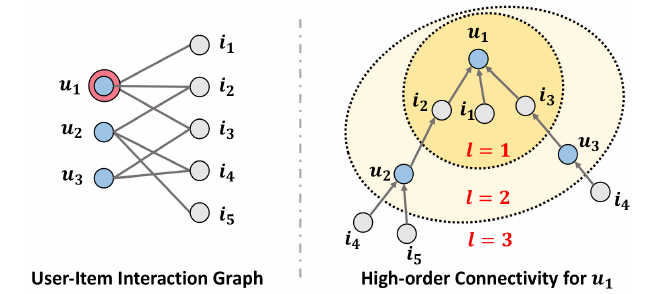

> **Observação**: as amostragens de usuários e de itens dos grafos abaixo fazem parte de apenas uma parte de todos os dados disponíveis. Essa técnica foi usada para que a exibição não ficasse poluída.

In [ ]:
# Código: funções de plotagem
def get_node_info(node_idx, num_users, user_map_reverse, item_map_reverse, item_id_to_title):
    if node_idx < num_users:
        user_orig_id = user_map_reverse.get(node_idx, '?')
        return f"User {user_orig_id}", "user", "#FF5733"
    else:
        item_idx = node_idx - num_users
        item_orig_id = item_map_reverse.get(item_idx, '?')
        title = item_id_to_title.get(item_orig_id, f"Item {item_idx}")
        max_len = 15
        title_short = (title[:max_len] + '...') if len(title) > max_len else title
        return title_short, "item", "#3357FF"

def plot_layered_neighborhood_graph(A_matrix, user_id_original, max_hop=1):
    G_full = nx.from_scipy_sparse_array(A_matrix)
    internal_user_id = -1
    for idx, orig_id in user_map_reverse.items():
        if orig_id == user_id_original:
            internal_user_id = idx 
            break
    if internal_user_id == -1:
        print(f"  Aviso: Usuário {user_id_original} não encontrado para plotar grafo L={max_hop}.")
        return

    SAMP_L1 = 7 
    SAMP_L2 = 3
    SAMP_L3 = 2
    
    G_plot = nx.Graph()
    labels = {}
    colors = {}
    pos = {}
    layer_nodes = {0: [internal_user_id]}
    all_nodes_in_plot = {internal_user_id}
    user_label, _, user_color = get_node_info(
        internal_user_id, 
        num_users, 
        user_map_reverse, 
        item_map_reverse, 
        item_id_to_title
    )
    
    G_plot.add_node(internal_user_id)
    labels[internal_user_id] = user_label
    colors[internal_user_id] = user_color

    for hop in range(max_hop):
        layer_nodes[hop+1] = []; nodes_in_next_layer_this_pass = set()
        for node_in_current_layer in layer_nodes[hop]:
            neighbors = list(G_full.neighbors(node_in_current_layer))
            is_user_node = node_in_current_layer < num_users
            if hop == 0: 
                sample_size = SAMP_L1
            elif hop == 1 and not is_user_node: 
                sample_size = SAMP_L2
            elif hop == 2 and is_user_node: 
                sample_size = SAMP_L3
            else: 
                sample_size = 1
            
            valid_neighbors = [n for n in neighbors if n not in all_nodes_in_plot and n not in nodes_in_next_layer_this_pass]
            sampled_neighbors = random.sample(valid_neighbors, min(len(valid_neighbors), sample_size))
            for neighbor_node in sampled_neighbors:
                neighbor_label, _, neighbor_color = get_node_info(
                    neighbor_node, 
                    num_users, 
                    user_map_reverse, 
                    item_map_reverse, 
                    item_id_to_title
                )
                
                if neighbor_node not in G_plot: 
                    G_plot.add_node(neighbor_node)
                
                G_plot.add_edge(node_in_current_layer, neighbor_node)
                labels[neighbor_node] = neighbor_label
                colors[neighbor_node] = neighbor_color
                
                layer_nodes[hop+1].append(neighbor_node)
                all_nodes_in_plot.add(neighbor_node)
                nodes_in_next_layer_this_pass.add(neighbor_node)
        
        if not layer_nodes[hop+1]:
             if hop + 1 in layer_nodes: 
                del layer_nodes[hop+1]
                break

    max_nodes_in_layer = max(len(nodes) for nodes in layer_nodes.values()) if layer_nodes else 1
    
    y_scale = max(8, max_nodes_in_layer)
    x_scale = max(4, max_hop * 1.5)
    
    for hop, nodes_in_layer in layer_nodes.items():
        y_coords = np.linspace(-y_scale/2, y_scale/2, len(nodes_in_layer)) if len(nodes_in_layer) > 1 else [0]
        for i, node_id in enumerate(nodes_in_layer): 
            pos[node_id] = (hop * (x_scale / max(1,max_hop)), y_coords[i])

    fig_width = max(6, max_hop * 2)
    fig_height = max(6, y_scale * 0.4)
    plt.figure(figsize=(fig_width, fig_height))
    
    node_size = 800
    font_size = 6
    nx.draw(
        G_plot, 
        pos=pos, 
        labels=labels, 
        node_color=[colors.get(n, '#CCCCCC') for n in G_plot.nodes()], 
        node_size=node_size, 
        font_size=font_size, 
        font_weight='normal', 
        width=0.5, 
        alpha=0.8, 
        edge_color='gray', 
        with_labels=True
    )
    
    plt.title(f"Grafo Vizinhança (L={max_hop}), User {user_id_original}", size=10)
    legend_elements = [
        Line2D(
            [0], 
            [0], 
            marker='o', 
            color='w', 
            label='Usuário', 
            markerfacecolor='#FF5733', 
            markersize=8
        ), 
        Line2D(
            [0], 
            [0], 
            marker='o', 
            color='w', 
            label='Item', 
            markerfacecolor='#3357FF', 
            markersize=8
        )
    ]
    
    plt.legend(
        handles=legend_elements, 
        loc='upper right', 
        bbox_to_anchor=(1.15, 1.0), 
        fontsize=8
    )
    
    filename = f'neighborhood_layered_L{max_hop}.png'
    plt.savefig(filename, dpi=150)
    print(f"  Grafo L = {max_hop} salvo como '{filename}'")

print('\nGerando grafos de vizinhança (L= 1, 2, 3):')
plot_layered_neighborhood_graph(A_mat, USER_ID_TEST, max_hop=1)
plot_layered_neighborhood_graph(A_mat, USER_ID_TEST, max_hop=2)
plot_layered_neighborhood_graph(A_mat, USER_ID_TEST, max_hop=3)

**Amostras de Atributos Nós do Grafo:**

In [ ]:
# Mostrar alguns nós do grafo (amostra)
G_sample = nx.from_scipy_sparse_array(A_mat)
print('Número total de nós (usuários+itens):', G_sample.number_of_nodes())
print('Número total de arestas:', G_sample.number_of_edges())
print('\nVizinhos do usuário interno 0 (se existirem):')
print(list(G_sample.neighbors(0)))

## Seção 5 — **Preparação do Dataset para Treinamento com BPR**

O `BPRDataset` é projetado para gerar **tripletas (usuário, item positivo, item negativo)** para treinar o NGCF com **BPR loss**, que otimiza a ordem relativa entre itens que o usuário prefere e itens que ele não interagiu.

- Cada **usuário** pode aparecer em múltiplas tripletas, correspondendo a cada **item positivo** com o qual ele interagiu no conjunto de treino.  
- O **item positivo** (`pos_item`) é sempre retirado do histórico real do usuário.  
- O **item negativo** (`neg_item`) é amostrado aleatoriamente de todos os itens, **garantindo que não faça parte do histórico do usuário**. Por isso, o mesmo usuário pode ter diferentes itens negativos em cada tripla.

O `DataLoader` combina essas tripletas em batches, embaralhando-as, para que o NGCF possa treinar eficientemente em mini-lotes, aprendendo embeddings de usuários e itens que refletem suas interações históricas e preferências implícitas.

In [ ]:
class BPRDataset(Dataset):
    def __init__(self, df, num_items, user_positive_map):
        self.positive_pairs = df[['user_id', 'item_id']].values; self.num_items = num_items; self.user_positive_map = user_positive_map
    def __len__(self): return len(self.positive_pairs)
    def __getitem__(self, idx):
        user, pos_item = self.positive_pairs[idx]; neg_item = random.randint(0, self.num_items - 1)
        while neg_item in self.user_positive_map.get(user, set()): neg_item = random.randint(0, self.num_items - 1)
        return user, pos_item, neg_item

bpr_dataset = BPRDataset(train_df, num_items, train_user_positive_map)
train_loader = DataLoader(bpr_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Mostrar 5 amostras (u, i+, j-)
print('\nExemplos do BPRDataset:')
for idx in range(5):
    try:
        u_, p_, n_ = bpr_dataset[idx]
        print(f'  {idx}: user={u_}, pos={p_}, neg={n_}')
    except Exception as e:
        print('  (erro ao acessar amostra)', e)

Exemplo de como interpretar os dados acima:

| idx | user | pos_item | neg_item |
|-----|------|----------|----------|
| 0   | 0    | 167      | 1610     |
| 1   | 0    | 171      | 279      |
| 2   | 0    | 164      | 1477     |
| 3   | 0    | 155      | 839      |
| 4   | 0    | 195      | 872      |

- Note que o **mesmo usuário (0)** aparece em múltiplas linhas, cada vez com um **item positivo diferente** e um **item negativo aleatório**.  
- Isso garante que o modelo aprenda tanto a **distinção entre itens preferidos e não preferidos** quanto a **variedade de preferências de cada usuário**.


## Seção 6 — Implementação do NGCF: Código e Conexões com o Paper

O NGCF (Neural Graph Collaborative Filtering) é um modelo de recomendação baseado em grafos que propaga embeddings de usuários e itens para capturar relações de alta ordem em um grafo bipartido. No código apresentado, a classe `NGCF` implementa diretamente os conceitos e equações do paper de Wang et al., SIGIR 2019.

1.  **Embeddings iniciais (`E0`)**: cada nó (usuário ou item) recebe um embedding inicial de dimensão `embed_dim`. Isso corresponde à tabela de embeddings $E$ (contendo $e_u$ e $e_i$) descrita na **Seção 2.1, Equação (1)**. Esses embeddings servem como a representação da camada 0, $E^{(0)}$, para o processo de propagação (conforme definido na **Seção 2.2.2**). A inicialização Xavier (mencionada na **Seção 4.2.3**) é usada no código.

2.  **Pesos das camadas (`W1s`, `W2s`) e Propagação**: o modelo possui `num_layers` camadas. O `forward` pass do código implementa diretamente a **Equação (7)** da **Seção 2.2.2**, que é a forma matricial da regra de propagação de alta ordem:

    $$E^{(l)} = \text{LeakyReLU}((\mathcal{L}+I)E^{(l-1)}W_1^{(l)} + \mathcal{L}(E^{(l-1)} \odot E^{(l-1)})W_2^{(l)})$$

    * `term1` no código corresponde a $(\mathcal{L}+I)E^{(l-1)}W_1^{(l)}$, usando `L_plus_I_tensor` (que representa $\mathcal{L}+I$, incluindo self-loops) e `W1s[l]`.
    * `term2` no código corresponde a $\mathcal{L}(E^{(l-1)} \odot E^{(l-1)})W_2^{(l)}$, usando `L_norm_tensor` (a Laplaciana $\mathcal{L}$ [cite: 204, 206][cite_start]) e `W2s[l]`.
    * Os pesos `W1s` e `W2s` no código são os $W_1^{(l)}$ e $W_2^{(l)}$ da equação, que são as matrizes de transformação treináveis para cada camada $l$.

3. **Forward pass e concatenação de camadas**: o `forward` pass aplica a regra de propagação (Equação 7) iterativamente por `num_layers`. Após todas as camadas, os embeddings de cada camada (de $E^{(0)}$ até $E^{(L)}$) são **concatenados** para formar o embedding final $e^*$. Isso corresponde à **Equação (9)** da **Seção 2.3** ($e_{u}^{*} = e_{u}^{(0)}||\cdot\cdot\cdot||e_{u}^{(L)}$), que incorpora informações de vizinhança de ordens diferentes.

4. **Função de previsão (`predict`)**: para cada usuário e item, o código calcula a pontuação de afinidade ($\hat{y}_{NGCF}(u,i)$) usando o produto escalar entre os embeddings finais concatenados ($e_u^*$ e $e_i^*$). Isso implementa a **Equação (10)** da **Seção 2.3**. Essas pontuações (para pares positivos `pos_i` e negativos `neg_j`) são então usadas para otimizar a BPR loss, conforme descrito na **Seção 2.4, Equação (11)**.

Em resumo, o código implementa todos os elementos centrais do NGCF: embeddings iniciais (Eq. 1), propagação multi-camada em forma matricial (Eq. 7) com termos lineares e interativos, e concatenação de camadas (Eq. 9), para finalmente gerar uma pontuação (Eq. 10) para a BPR loss (Eq. 11). Cada componente está diretamente relacionado às equações do paper, garantindo que a implementação capture as interações implícitas e de alta ordem entre usuários e itens no grafo bipartido.

In [ ]:
class NGCF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim, num_layers, L_norm_tensor, L_plus_I_tensor):
        super(NGCF, self).__init__()
        self.num_users=num_users
        self.num_items=num_items
        self.num_nodes=num_users+num_items
        self.embed_dim=embed_dim
        self.num_layers=num_layers
        
        self.register_buffer('L_norm_tensor', L_norm_tensor)
        self.register_buffer('L_plus_I_tensor', L_plus_I_tensor)
        
        self.E0 = nn.Embedding(self.num_nodes, self.embed_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.W1s = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(num_layers)])
        self.W2s = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(num_layers)])

    def forward(self):
        E = self.E0.weight; all_E = [E]
        for l in range(self.num_layers):
            term1 = torch.sparse.mm(self.L_plus_I_tensor, E)
            term1 = self.W1s[l](term1)
            term2 = E * E
            term2 = torch.sparse.mm(self.L_norm_tensor, term2)
            term2 = self.W2s[l](term2)
            E_l = F.leaky_relu(term1 + term2)
            E = E_l
            all_E.append(E_l)
        return torch.cat(all_E, dim=1)

    def predict(self, E_final, u_batch, i_batch, j_batch):
        e_u_final, e_i_final = torch.split(E_final, [self.num_users, self.num_items], dim=0)
        u_embeds = e_u_final[u_batch]
        pos_i = e_i_final[i_batch]
        neg_j = e_i_final[j_batch]
        return (u_embeds * pos_i).sum(dim=1), (u_embeds * neg_j).sum(dim=1)

ngcf_model = NGCF(num_users, num_items, EMBED_DIM, NUM_LAYERS, L_norm_tensor, L_plus_I_tensor).to(DEVICE)
print('\nModelo NGCF instanciado.\n')
print('Shape E0.weight:', ngcf_model.E0.weight.shape)
print('Primeiros 10 valores do E0 para o nó 0:')
print(ngcf_model.E0.weight[0:2, :10].detach().cpu().numpy())
with torch.no_grad():
    E_concat = ngcf_model()
print('\nShape de E* concatenado:', E_concat.shape)
print('Exemplo (primeiros 10 dimensões do nó 0):')
print(E_concat[0:2, :10].cpu().numpy())

## Seção 7 — Treinamento do Modelo

Loop de treinamento usando BPR loss + regularização L2. 

Avaliamos no conjunto de validação a cada época.

In [ ]:
# Função de avaliação (val/test) — calcula métricas top-K
def evaluate_ngcf_epoch(model, eval_map, train_map, k):
    model.eval()
    all_metrics = {'prec': [], 'rec': [], 'ndcg': [], 'mrr': []}
    with torch.no_grad():
        E_final = model()
        e_u_final, e_i_final = torch.split(E_final, [num_users, num_items], dim=0)

    for user_idx, ground_truth_items in eval_map.items():
        if user_idx >= num_users: continue
        e_u_star = e_u_final[user_idx]
        all_scores = e_u_star @ e_i_final.T
        seen_train_items = train_map.get(user_idx, set())
        all_scores[list(seen_train_items)] = -np.inf
        _, top_k_indices = torch.topk(all_scores, k)
        top_k_items = top_k_indices.cpu().numpy()
        hits = set(top_k_items) & ground_truth_items
        num_hits = len(hits)
        all_metrics['prec'].append(num_hits / k)
        all_metrics['rec'].append(num_hits / len(ground_truth_items))
        ndcg, mrr = 0.0, 0.0
        if num_hits > 0:
            for i, item in enumerate(top_k_items):
                if item in ground_truth_items:
                    rank = i + 1
                    ndcg = 1.0 / np.log2(rank + 1)
                    mrr = 1.0 / rank
                    break
        all_metrics['ndcg'].append(ndcg)
        all_metrics['mrr'].append(mrr)

    return {m: np.mean(vals) for m, vals in all_metrics.items()}

# Treinamento (executar quando quiser — pode demorar dependendo do ambiente)
optimizer = optim.Adam(ngcf_model.parameters(), lr=LR)
loss_history = []
precision_history = []
recall_history = []
ndcg_history = []
mrr_history = []

final_embeddings_example = None

print('\nIniciando treinamento:')
for epoch in range(EPOCHS):
    ngcf_model.train()
    total_loss = 0.0
    for u_batch, i_batch, j_batch in train_loader:
        u_batch=u_batch.to(DEVICE); i_batch=i_batch.to(DEVICE); j_batch=j_batch.to(DEVICE)
        optimizer.zero_grad(); E_final = ngcf_model()
        pos_scores, neg_scores = ngcf_model.predict(E_final, u_batch, i_batch, j_batch)
        bpr_loss = F.softplus(neg_scores - pos_scores).mean()
        l2_loss = sum(p.pow(2).sum() for p in ngcf_model.parameters()) * 0.5 * L2_REG
        loss = bpr_loss + l2_loss
        loss.backward(); optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / max(1, len(train_loader))
    loss_history.append(avg_loss)
    val_metrics = evaluate_ngcf_epoch(ngcf_model, val_user_positive_map, train_user_positive_map, k=TOP_K)
    precision_history.append(val_metrics['prec'])
    recall_history.append(val_metrics['rec'])
    ndcg_history.append(val_metrics['ndcg'])
    mrr_history.append(val_metrics['mrr'])

    if epoch == EPOCHS - 1:
        with torch.no_grad(): final_embeddings_example = ngcf_model().detach()

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"  Epoch {epoch+1:2d}/{EPOCHS} - Loss: {avg_loss:.4f} | Val Recall@{TOP_K}: {val_metrics['rec']:.4f} | Val NDCG@{TOP_K}: {val_metrics['ndcg']:.4f}")

print('Treinamento finalizado.')

## Seção 8 — Avaliação Final e Geração de Recomendações

### **Treinamento do NGCF e evolução de métricas**

Durante o treinamento, o modelo NGCF é otimizado usando **BPR loss** combinada com regularização L2. Para cada batch, o código calcula:

- `bpr_loss`: encoraja o modelo a atribuir scores mais altos para itens positivos do que para negativos.  
- `l2_loss`: penaliza grandes valores nos pesos do modelo para evitar overfitting.  
- `loss = bpr_loss + l2_loss`: perda total usada para atualizar os embeddings e pesos.

A cada época, o modelo é avaliado no **conjunto de validação** para calcular métricas top-K:  

- **Precision@K**: proporção de itens recomendados no top-K que são relevantes.  
- **Recall@K**: proporção de itens relevantes recuperados no top-K.  
- **NDCG@K**: métrica que considera a posição dos itens relevantes no ranking.  
- **MRR@K**: reciprocidade da posição do primeiro item relevante encontrado.

Essas métricas permitem monitorar se o modelo está aprendendo a capturar as preferências dos usuários corretamente, sem expor dados de teste.  

In [ ]:
# Plot da evolução da loss e métricas de validação
plt.figure(figsize=(14, 5))

# 1) Evolução da Loss
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Train Loss', color='red', marker='o')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução da Loss durante o Treinamento')
plt.grid(True)
plt.legend()

# 2) Evolução das métricas de validação
plt.subplot(1, 2, 2)
plt.plot(precision_history, label='Precision@K', marker='o')
plt.plot(recall_history, label='Recall@K', marker='s')
plt.plot(ndcg_history, label='NDCG@K', marker='^')
plt.plot(mrr_history, label='MRR@K', marker='d')
plt.xlabel('Época')
plt.ylabel('Valor da Métrica')
plt.title('Evolução das Métricas de Validação')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### **Recomendação TOP-K e Métricas do Teste**

In [ ]:
# Função para obter top-n recomendações (com títulos originais)
def get_top_n_recommendations_ngcf(model, user_id_original, train_map, n=TOP_K):
    model.eval(); recommendations = []
    with torch.no_grad():
        E_final = model(); e_u_final, e_i_final = torch.split(E_final, [num_users, num_items], dim=0)
    internal_user_id = -1
    for idx, orig_id in user_map_reverse.items():
        if orig_id == user_id_original: internal_user_id = idx; break
    if internal_user_id == -1: print(f"  Usuário {user_id_original} não encontrado."); return None
    e_u_star = e_u_final[internal_user_id]; all_scores = e_u_star @ e_i_final.T
    seen_items_idx = train_map.get(internal_user_id, set()); all_scores[list(seen_items_idx)] = -np.inf
    top_scores, top_indices = torch.topk(all_scores, n)
    for score, idx in zip(top_scores.cpu().numpy(), top_indices.cpu().numpy()):
        original_item_id = item_map_reverse.get(int(idx), -1)
        title = item_id_to_title.get(original_item_id, f"?")
        recommendations.append((original_item_id, title, f"{float(score):.4f}"))
    return recommendations

print('\nGerando recomendações exemplo para usuário', USER_ID_TEST)
top_recs_example = get_top_n_recommendations_ngcf(ngcf_model, USER_ID_TEST, train_user_positive_map, n=TOP_K)
if top_recs_example:
    recs_df = pd.DataFrame(top_recs_example, columns=["ID Original", "Título", "Pontuação"])
    print(recs_df.to_markdown(index=False))
else:
    print('Nenhuma recomendação gerada.')

# Avaliação final no conjunto de teste
print('\nCalculando métricas finais no conjunto de teste...')
test_metrics = evaluate_ngcf_epoch(ngcf_model, test_user_positive_map, train_user_positive_map, k=TOP_K)
print('\nMétricas finais (Test):')
print(f"Precision@{TOP_K}: {test_metrics['prec']:.4f}")
print(f"Recall@{TOP_K}:    {test_metrics['rec']:.4f}")
print(f"NDCG@{TOP_K}:      {test_metrics['ndcg']:.4f}")
print(f"MRR@{TOP_K}:       {test_metrics['mrr']:.4f}")

### **Plot Final de Recomendação (Histórico + Top-k)**

In [ ]:
# Função para plotar grafo de recomendação do usuário
def plot_recommendation_graph(user_id_original, top_recs_list, train_map):
    if not top_recs_list: return
    internal_user_id = -1
    for idx, orig_id in user_map_reverse.items():
        if orig_id == user_id_original: internal_user_id = idx; break
    if internal_user_id == -1: print(f"  Aviso: Usuário {user_id_original} não encontrado."); return

    positive_item_indices = list(train_map.get(internal_user_id, set()))
    sample_pos_indices = random.sample(positive_item_indices, min(len(positive_item_indices), 10)) if positive_item_indices else []
    pos_items = [item_id_to_title.get(item_map_reverse.get(idx,-1), "?") for idx in sample_pos_indices]
    rec_items = [title for _, title, _ in top_recs_list]

    G = nx.Graph(); user_node = f"Usuário {user_id_original}"; G.add_node(user_node, type='user')
    for title in pos_items: G.add_node(title, type='history'); G.add_edge(user_node, title)
    for title in rec_items: G.add_node(title, type='recommendation'); G.add_edge(user_node, title)

    plt.figure(figsize=(8, 8)); pos = nx.spring_layout(G, k=1.0, iterations=50, scale=1.5)
    node_size = 1200; font_size = 7; label_max_len = 20
    labels = {node: (node[:label_max_len] + '...') if len(node)>label_max_len else node for node in G.nodes()}
    node_colors = ['#FF5733' if G.nodes[n]['type']=='user' else ('#33FF57' if G.nodes[n]['type']=='history' else '#3357FF') for n in G.nodes()]

    nx.draw(G, pos, labels=labels, node_color=node_colors, node_size=node_size, font_size=font_size, font_weight='normal', width=0.6, alpha=0.8, edge_color='gray')
    plt.title(f"Grafo Recomendação Final, User {user_id_original}", size=12)
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Usuário', markerfacecolor='#FF5733', markersize=10), Line2D([0], [0], marker='o', color='w', label='Histórico (Treino)', markerfacecolor='#33FF57', markersize=10), Line2D([0], [0], marker='o', color='w', label='Recomendação (Top-N)', markerfacecolor='#3357FF', markersize=10)]
    plt.legend(handles=legend_elements, loc='best', fontsize=9)
    filename = 'recommendation_final_graph.png'
    plt.savefig(filename, dpi=150)
    print(f"  Grafo final salvo como '{filename}'")

if top_recs_example:
    plot_recommendation_graph(USER_ID_TEST, top_recs_example, train_user_positive_map)


## Seção 9 - Benchmarking

Para atender aos requisitos do projeto, é necessário realizarmos comparações visuais e quantitativas por meio de um benchmarking. 

### Bibliotecas Auxiliares

In [ ]:
import faiss
from scipy.sparse import csr_matrix
from surprise import Dataset, Reader
from surprise import SVD, SVDpp, NMF, BaselineOnly, CoClustering
from surprise import KNNBasic, KNNWithMeans, KNNBaseline

### Dados de Treinamento para Novas Bibliotecas

In [ ]:
# Construir train_matrix a partir de train_user_positive_map
num_users = max(train_user_positive_map.keys()) + 1
num_items = max(max(items) for items in train_user_positive_map.values()) + 1

rows, cols = [], []
for u, items in train_user_positive_map.items():
    for it in items:
        rows.append(u)
        cols.append(it)

data = np.ones(len(rows), dtype=np.float32)
train_matrix = csr_matrix((data, (rows, cols)), shape=(num_users, num_items))
print("Matriz de treinamento criada:", train_matrix.shape)

#### FAISS

In [ ]:
# Preparar matrizes densas para FAISS

# Cada usuário: vetor de itens (num_items)
user_dense = np.ascontiguousarray(train_matrix.toarray().astype("float32"))
faiss.normalize_L2(user_dense)

# Cada item: vetor de usuários (num_users)
item_dense = np.ascontiguousarray(train_matrix.T.toarray().astype("float32"))
faiss.normalize_L2(item_dense)

# Índices FAISS
index_items = faiss.IndexFlatIP(item_dense.shape[1])  # dim = num_users
index_items.add(item_dense)
index_users = faiss.IndexFlatIP(user_dense.shape[1])  # dim = num_items
index_users.add(user_dense)

### Funções Axiliares

In [ ]:
# Função de avaliação Top-K
def evaluate_topk(recommender_fn, k):
    precs, recs, ndcgs, mrrs = [], [], [], []

    for user, positives in test_user_positive_map.items():
        positives = set(positives)
        rec = recommender_fn(user, k)
        hits = [1 if r in positives else 0 for r in rec]
        n_pos = len(positives)

        p = sum(hits) / k
        r = sum(hits) / n_pos if n_pos else 0

        dcg = sum(hits[i] / np.log2(i + 2) for i in range(k))
        idcg = sum(1 / np.log2(i + 2) for i in range(min(n_pos, k)))
        n = dcg / idcg if idcg else 0

        m = next((1/(i+1) for i,h in enumerate(hits) if h), 0)

        precs.append(p)
        recs.append(r)
        ndcgs.append(n)
        mrrs.append(m)

    return dict(
        prec=np.mean(precs),
        rec=np.mean(recs),
        ndcg=np.mean(ndcgs),
        mrr=np.mean(mrrs),
    )

### Execuções dos Algoritmos

#### Baselines: Popularidade e Aleatório

In [ ]:
# Baselines: Popularity e Random
item_popularity = np.zeros(num_items)
for items in train_user_positive_map.values():
    for it in items:
        item_popularity[it] += 1
pop_sorted = np.argsort(-item_popularity)

def rec_pop(user, k):
    seen = set(train_user_positive_map[user])
    return [it for it in pop_sorted if it not in seen][:k]

def rec_random(user, k):
    seen = set(train_user_positive_map[user])
    candidates = np.setdiff1d(np.arange(num_items), list(seen))
    np.random.shuffle(candidates)
    return candidates[:k]

#### FAISS

In [ ]:
# FAISS KNN
def rec_item_faiss(user, k):
    seen = set(train_user_positive_map[user])
    # vetor do usuário como shape (1, num_users) -> cada posição corresponde a um usuário
    # Para produto interno, usamos vetor de usuário original (one-hot)
    user_vec = np.zeros((1, num_users), dtype='float32')
    user_vec[0, user] = 1.0
    faiss.normalize_L2(user_vec)
    _, idxs = index_items.search(user_vec, k + len(seen) + 50)
    idxs = [i for i in idxs[0] if i not in seen]
    return idxs[:k]

def rec_user_faiss(user, k, n_neighbors=50):
    seen = set(train_user_positive_map[user])
    _, neigh = index_users.search(user_dense[user].reshape(1,-1), n_neighbors)
    neigh = [n for n in neigh[0] if n != user]

    agg = np.sum(train_matrix[neigh].toarray(), axis=0)
    agg[list(seen)] = -1e9

    top = np.argpartition(agg, -k)[-k:]
    return top[np.argsort(agg[top])[::-1]].tolist()

#### Surprise

In [ ]:
# Surprise
triplets = [(u, it, 1) for u, items in train_user_positive_map.items() for it in items]
df_sur = pd.DataFrame(triplets, columns=["user","item","rating"])
trainset = Dataset.load_from_df(df_sur, Reader(rating_scale=(0,1))).build_full_trainset()

def surprise_rec(model):
    def fn(user, k):
        seen = set(train_user_positive_map[user])
        scores = [(it, model.predict(user, it).est) for it in range(num_items) if it not in seen]
        return [i for i,_ in sorted(scores, key=lambda x:-x[1])[:k]]
    return fn

surprise_algos = {
    "SVD": SVD(),
    "SVD++": SVDpp(),
    "NMF": NMF(),
    "BaselineOnly": BaselineOnly(),
    "KNNBasic": KNNBasic(sim_options={"name":"cosine","user_based":True}),
    "KNNWithMeans": KNNWithMeans(),
    "KNNBaseline": KNNBaseline(),
    "CoClustering": CoClustering(),
}

### Execução Completa

In [ ]:
# Executar todos os algoritmos

results = {}
steps = [
    ("Popularity", lambda: evaluate_topk(rec_pop, TOP_K)),
    ("Random", lambda: evaluate_topk(rec_random, TOP_K)),
    ("ItemKNN_FAISS", lambda: evaluate_topk(rec_item_faiss, TOP_K)),
    ("UserKNN_FAISS", lambda: evaluate_topk(lambda u,k: rec_user_faiss(u,k), TOP_K)),
]

# Adicionando Surprise
for name, algo in surprise_algos.items():
    steps.append((f"Surprise_{name}", algo))

# Adicionando NGCF (se já treinado)
if 'test_metrics' in globals():
    steps.append(("NGCF", lambda: test_metrics))

# Rodar todos
for idx, (name, algo) in enumerate(steps, 1):
    print(f"[{idx}/{len(steps)}] Rodando {name}...")
    if "Surprise_" in name:
        algo.fit(trainset)
        results[name] = evaluate_topk(surprise_rec(algo), TOP_K)
    else:
        results[name] = algo() if callable(algo) else algo

### Tabela

In [ ]:
results_df = pd.DataFrame(results).T  # algoritmos nas linhas
metric_labels = {"prec":"Precisão","rec":"Revocação","ndcg":"NDCG","mrr":"MRR"}
results_df = results_df.rename(columns=metric_labels)
print(results_df.to_markdown())         # para console/script

### Comparação Gráfica

In [ ]:
plot_df = results_df.copy()
metrics = plot_df.columns.tolist()
n_metrics = len(metrics)

# Cores consistentes para cada algoritmo
algorithms = plot_df.index.tolist()
colors = plt.get_cmap("tab20")(np.linspace(0,1,len(algorithms)))
color_map = dict(zip(algorithms, colors))

# Preparar posições
bar_width = 0.7 / len(algorithms)
x = np.arange(n_metrics)

plt.figure(figsize=(22,10))  # gráfico bem grande

for i, metric in enumerate(metrics):
    # ordenar algoritmos dentro da métrica
    sorted_algos = plot_df[metric].sort_values(ascending=False)
    for j, algo in enumerate(sorted_algos.index):
        plt.bar(x[i] + j*bar_width, sorted_algos[algo], width=bar_width, color=color_map[algo])

# Ajustar ticks e labels
tick_positions = x + (len(algorithms)-1)*bar_width/2
plt.xticks(tick_positions, metrics, fontsize=28, fontweight='bold')
plt.yticks(fontsize=24)
plt.ylabel("Valor da Métrica", fontsize=28, fontweight='bold')
plt.xlabel("Métrica", fontsize=28, fontweight='bold')
plt.title("Benchmark Geral — Algoritmos ordenados dentro de cada métrica", fontsize=36, fontweight='bold')

# Legenda e Grid
handles = [Line2D([0],[0], color=color_map[algo], lw=12, label=algo) for algo in algorithms]
plt.legend(handles=handles, bbox_to_anchor=(1.05,1), loc='upper left', fontsize=22)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
